### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

### Loading necessary files

In [2]:
train_df = pd.DataFrame(json.load(open( 'train_data.json', 'r')))
test_df = pd.DataFrame(json.load(open( 'test_data.json', 'r')))
metric_embeddings = np.load( 'metric_name_embeddings.npy')
metric_names = json.load(open( 'metric_names.json', 'r'))

### Exploratory Data Analysis

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   metric_name    5000 non-null   object
 1   score          5000 non-null   object
 2   user_prompt    5000 non-null   object
 3   response       4999 non-null   object
 4   system_prompt  3451 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


 - Score is of type object, while it is an integer belonging to [0,10] as per the problem statement, hence converting it to float type.

In [4]:
train_df['score'] = train_df['score'].astype('float')

- Response and system prompts have null values, hence filling with ''

In [5]:
train_df.fillna('',inplace = True)

### Visualing the Data

In [6]:
train_df['score'].describe()

,score
count,5000.000000
mean,9.119500
std,0.942416
min,0.000000
25%,9.000000
50%,9.000000
75%,10.000000
max,10.000000


### We see that the distribution is extremely skewed, the mean is 9 with a standard deviation 1

In [7]:
train_df['score'].value_counts()

,count
score,
9.0,3123
10.0,1442
8.0,259
7.0,95
6.0,45
0.0,13
3.0,7
1.0,6
2.0,5


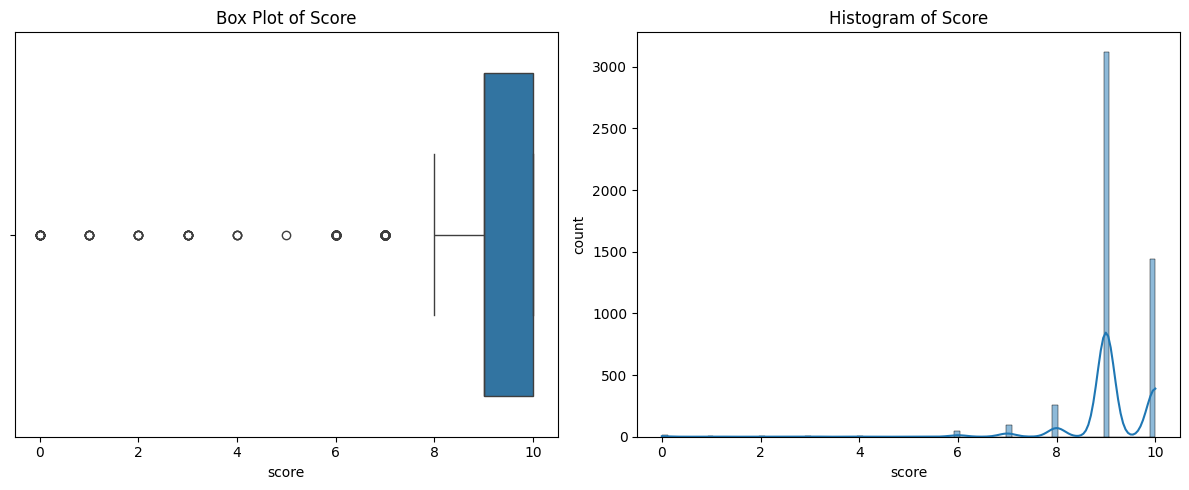

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
sns.boxplot(x=train_df['score'], ax=axes[0])
axes[0].set_title("Box Plot of Score")
axes[0].set_xlabel("score")

# Histogram
sns.histplot(train_df['score'], kde=True, ax=axes[1])
axes[1].set_title("Histogram of Score")
axes[1].set_xlabel("score")
axes[1].set_ylabel("count")

plt.tight_layout()
plt.show()

- There are literally no training examples for values <=5. No amount of generating synthetic data/ oversampling can fix this level of imbalance.
- Also these methods will lead to meaningless noise further confusing the model.

### Converting metric names to metric indices so that we can see the distribution of different metrics.

In [9]:
metric2idx = {i:idx for idx,i in enumerate(metric_names)}

In [10]:
train_df['metric_idx'] = train_df['metric_name'].map(metric2idx)

In [11]:
test_df['metric_idx'] = test_df['metric_name'].map(metric2idx)

In [12]:
train_df['metric_idx'].value_counts()

,count
metric_idx,
41,56
79,54
64,52
84,52
52,52
...,...
121,10
142,9
138,8


### Inspecting the balance of different metric distributions

Text(0, 0.5, 'count')

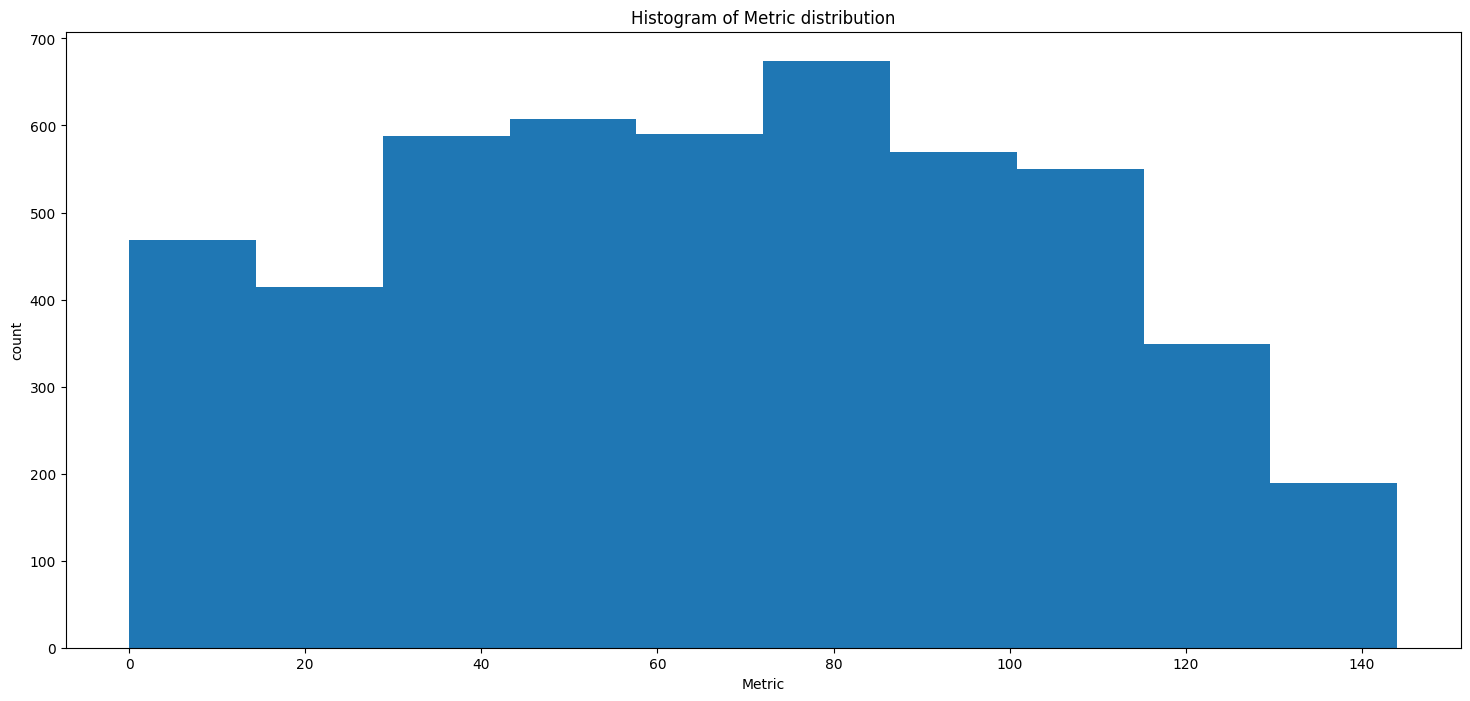

In [13]:
plt.figure(figsize=(18,8))
plt.hist(train_df['metric_idx'])
plt.title("Histogram of Metric distribution")
plt.xlabel("Metric")
plt.ylabel("count")

In [14]:
metric_counts = train_df['metric_idx'].value_counts()

In [15]:
metric_counts.value_counts().describe()

,count
count,44.000000
mean,3.295455
std,2.377995
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,9.000000


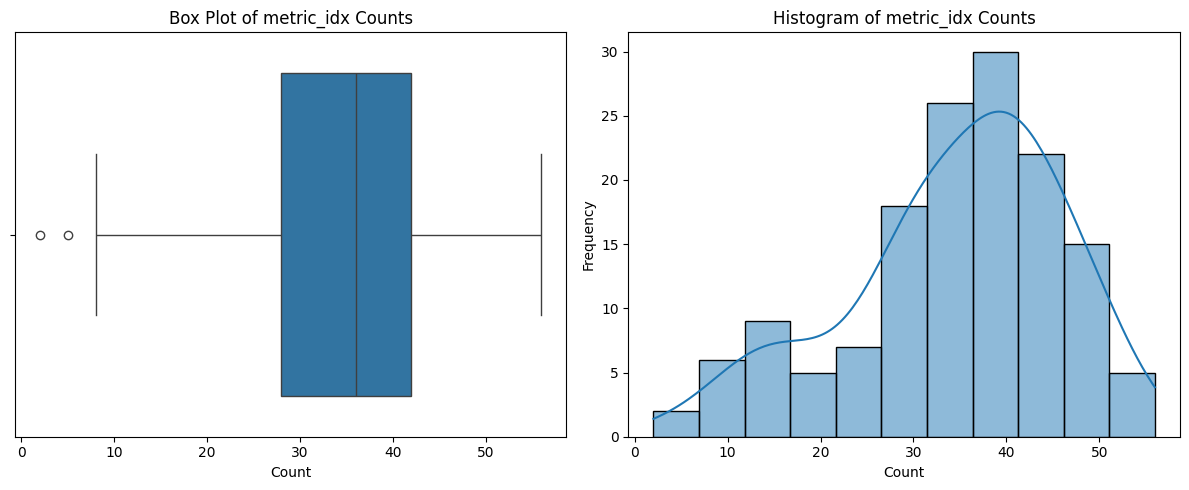

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
sns.boxplot(x=metric_counts, ax=axes[0])
axes[0].set_title("Box Plot of metric_idx Counts")
axes[0].set_xlabel("Count")

# Histogram
sns.histplot(metric_counts, kde=True, ax=axes[1])
axes[1].set_title("Histogram of metric_idx Counts")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [17]:
sum(metric_counts<=10)

5

- The metric counts are reasonably balanced, even though there are are metrics with very less examples.

- This amount of imbalance might not pose a serious threat as long as we make sure we dont overfit the model

### Addressing the Score Imbalance:

- The model has very few examples predicting low score, synthethic augmentation/oversampling will add more noise, making the model unstable

- Instead we can add real examples, even without getting the metric descriptions.

- The metrics that match very well with the prompt response pair (in this case majority of them do) are likely to give a bad match with some other prompt response pair.

- Hence, we sample random (metric, prompt response) pairs that have a high score(>8) and mix them up with some other highly matching (metric,prompt response) pair creating a new example with a low fitness score.

- The new samples have real language and structure. Interpolating the embeddings is highly likely to produce a meaningless thing in the embedding space, hence confusing the model

- This way, our model gets a reasonable number of examples in the low score range in a meaningful fashion as opposed to noisy synthetic augmentation.

- I will do this augmentation post generating embeddings for the text response pairs.

### Combining system prompt, user prompt, responses

In [18]:
def combine_text_features(row):
    prompt_text = f"[PROMPT:] {row['user_prompt']}"
    response_text = f"[RESPONSE:] {row['response']}"
    system_text = f"[SYSTEM_PROMPT:] {row['system_prompt']}" if row['system_prompt'] else ""

    return f"{prompt_text} {response_text} {system_text}"

train_df['combined_text'] = train_df.apply(combine_text_features, axis=1)
test_df['combined_text'] = test_df.apply(combine_text_features, axis=1)

In [20]:
from sentence_transformers import SentenceTransformer
import torch
import os

MODEL_NAME = "google/embeddinggemma-300m"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load the model
print(f"Loading SentenceTransformer model: {MODEL_NAME} on {DEVICE}...")
text_encoder = SentenceTransformer(
    MODEL_NAME,
    device=DEVICE
)

# 2. Encode Training Data
print("Starting encoding of training data...")
X_train_text = text_encoder.encode(
    train_df['combined_text'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False
)
np.save('X_train_text.npy', X_train_text)
print(f"X_train_text encoded and saved. Shape: {X_train_text.shape}")

# 3. Encode Test Data
print("Starting encoding of test data...")
X_test_text = text_encoder.encode(
    test_df['combined_text'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False
)
np.save('X_test_text.npy', X_test_text)
print(f"X_test_text encoded and saved. Shape: {X_test_text.shape}")

# 4. Final Concatenation (unchanged)
X_train_metric = metric_embeddings[train_df['metric_idx'].values]
X_test_metric = metric_embeddings[test_df['metric_idx'].values]

X_train = np.concatenate([X_train_metric, X_train_text], axis=1)
X_test = np.concatenate([X_test_metric, X_test_text], axis=1)
Y_train = train_df['score'].values

print(f"Final combined training feature shape: {X_train.shape}")


Loading SentenceTransformer model: google/embeddinggemma-300m on cuda...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

3_Dense/model.safetensors:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

Starting encoding of training data...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

X_train_text encoded and saved. Shape: (5000, 768)
Starting encoding of test data...


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

X_test_text encoded and saved. Shape: (3638, 768)
Final combined training feature shape: (5000, 1536)


### Now moving on to the augmentation part:

- Sampled 2 random (metric,prompt response) pairs having high scores (scores >= 9) and assigned a low-score to it (uniform(0,4)).

- Did this for every sample in high score bracket, making it a 1:1 augmentation (for every high score pair, created a pair with low score)

In [21]:
import random

positive_indices = np.where(Y_train >= 9.0)[0]
print(f"Augmenting {len(positive_indices)} high-score samples.")

X_aug_metric = []
X_aug_text = []
Y_aug = []

all_metric_indices = np.arange(len(metric_names))

for i in positive_indices: # for every sample with positive score

    original_metric_idx = train_df['metric_idx'].iloc[i]


    opponent_metric_idx = random.choice(all_metric_indices[all_metric_indices != original_metric_idx]) # sample another metric


    new_metric_embedding = metric_embeddings[opponent_metric_idx] # giving the metric its opponents metric


    original_text_embedding = X_train_text[i]

    new_score = np.random.uniform(0.0, 4.0) # assigning a low score.

    X_aug_metric.append(new_metric_embedding)
    X_aug_text.append(original_text_embedding)
    Y_aug.append(new_score)


X_train_metric = np.concatenate([X_train_metric, np.array(X_aug_metric)], axis=0)
X_train_text = np.concatenate([X_train_text, np.array(X_aug_text)], axis=0)
Y_train = np.concatenate([Y_train, np.array(Y_aug)], axis=0)

print(f"Total training samples after augmentation: {X_train_metric.shape[0]}")


Augmenting 4566 high-score samples.
Total training samples after augmentation: 9566


### This way we have meaningfully doubled the number of samples available, reasonably balancing the distribution.

### Feature Engineering

- The problem statement states that the score/fitness is based on distance learning.

- hence adding distance based features helps the model build a better correlation.

### These features are :

- element wise difference = |X_metric – X_text| → measures how much the two embeddings disagree in each dimension.

- Element wise products = X_metric * X_text → measures how strongly the two embeddings agree or align in each dimension.

In [22]:
diff_train = np.abs(X_train_metric - X_train_text)
prod_train = (X_train_metric * X_train_text)
diff_test = np.abs(X_test_metric - X_test_text)
prod_test = (X_test_metric * X_test_text)

X_train = np.concatenate([X_train_metric, X_train_text, diff_train, prod_train], axis=1)
X_test = np.concatenate([X_test_metric, X_test_text, diff_test, prod_test], axis=1)

### Creating the train validation split.

The variables are awkward, because of the naming conflicts (X_text is named after df_test, Which is for new prediction and not for model training)

In [23]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=42
)

print("Train:", X_tr.shape, " Val:", X_val.shape)


Train: (7652, 3072)  Val: (1914, 3072)


### Dimensionality reduction :    

- 3072 features are too much for any model to train on.

- First lets try PCA

Components needed for 95% variance: 895


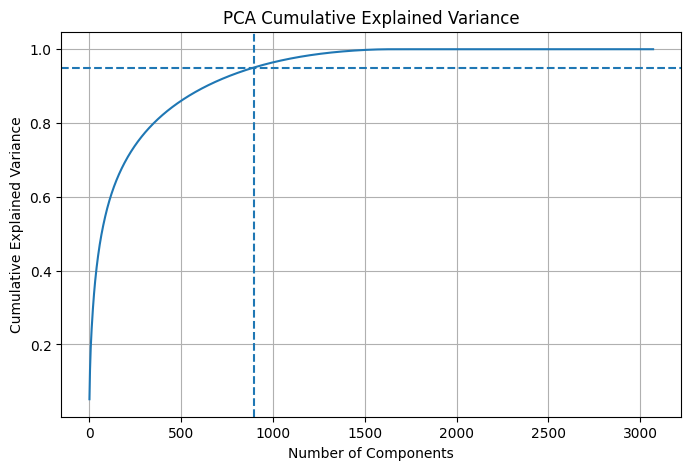

In [24]:
from sklearn.decomposition import PCA

# --- PCA ---
pca = PCA()
pca.fit(X_tr)

# Cumulative explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Components needed for 95%
k_95 = np.argmax(cumsum >= 0.95) + 1
print("Components needed for 95% variance:", k_95)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(cumsum)
plt.axhline(y=0.95, linestyle='--')
plt.axvline(x=k_95, linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid(True)
plt.show()


- We see 895 components are required for retaining 95 percent variance.

- This number is still too big for training a model.

- PCA based on covariance, captures only 'linear' relationships.

- The embeddings are high dimensional, rich in semantic information.

- Because of this, the relation between features are often non-linear.

- Hence PCA is not a reliable strategy to reduce the dimensions.

#### Exploring other non-linear dimensionality reduction techniques:

- While methods like UMAP and t-SNE can capture complex non-linear structures, they are mainly suited for visualization and do not provide a stable inverse transform.

- Instead, I chose to use an auto-encoder, which learns a non-linear compressed representation while still allowing reconstruction of the original feature space.

- This makes the latent space both expressive and usable for downstream tasks like regression.

- An auto-encoder is a neural network that learns to compress data into a lower-dimensional latent space and then reconstruct it back to the original form, effectively capturing non-linear patterns that simpler methods like PCA cannot.

- The latent space it projects onto is very similar to text embeddings produced by gemma, Its meaningful, preserves non-linear relations.

- We can project back our Original features with latent space embeddings with reasonable accuracy.

### Training the Auto Encoder :     

- I will use pytorch for the training the auto-encoder.

- pytorch has 'tensors' identical to numpy arrays. But these things are specifically designed for gradient based operations for back propagation.

- These 'tensors' are also designed to run faster on GPUs with 'CUDA' cores. I have used colab T4 GPU.

### Architecture of autoencoder:

- I will reduce the number of features to 256 using three hidden layers.

- The dimensionality reduces as 3072 --> 1024 (Hidden Layer 1) --> 512 (Hidden Layer 2) --> 256 (Final Hidden Layer 3/output reduced dimensions)

- I have used ReLU (Rectified Linear Unit) as the activation function. This introduces non-linearity in features.
 It is given as :
    **ReLU(x) = max(0, x)**
- When searched on the internet, i found this was the most widely used activation function for text-based models.

- I learned that it is computationally cheap, fast and avoids the vanishing gradient problem in its positive region.

In [25]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Converting everything into tensors for fast training, and supporting gradient based operations
X_tr_tensor  = torch.tensor(X_tr, dtype=torch.float32).to(DEVICE)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

y_tr_tensor = torch.tensor(y_tr, dtype=torch.float32).to(DEVICE)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(DEVICE)

In [26]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim=3072, reduced_dim=256):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, reduced_dim)
        )
        # Decoder (for reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(reduced_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon


In [27]:
BATCH = 256
NUM_EPOCHS = 30
lr = 1e-3

autoenc = Autoencoder(3072, 512).to(DEVICE)
optimizer = torch.optim.Adam(autoenc.parameters(), lr=lr)
loss_fn = nn.MSELoss()

dataset = torch.utils.data.TensorDataset(X_tr_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)

for epoch in range(NUM_EPOCHS):
    autoenc.train()
    total_loss = 0
    for xb, in loader:
        optimizer.zero_grad()
        z, x_recon = autoenc(xb)
        loss = loss_fn(x_recon, xb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {total_loss/len(loader):.4f}")


Epoch 1/30, Loss: 0.0006
Epoch 2/30, Loss: 0.0005
Epoch 3/30, Loss: 0.0005
Epoch 4/30, Loss: 0.0005
Epoch 5/30, Loss: 0.0004
Epoch 6/30, Loss: 0.0004
Epoch 7/30, Loss: 0.0004
Epoch 8/30, Loss: 0.0004
Epoch 9/30, Loss: 0.0004
Epoch 10/30, Loss: 0.0004
Epoch 11/30, Loss: 0.0004
Epoch 12/30, Loss: 0.0003
Epoch 13/30, Loss: 0.0003
Epoch 14/30, Loss: 0.0003
Epoch 15/30, Loss: 0.0003
Epoch 16/30, Loss: 0.0003
Epoch 17/30, Loss: 0.0003
Epoch 18/30, Loss: 0.0003
Epoch 19/30, Loss: 0.0003
Epoch 20/30, Loss: 0.0003
Epoch 21/30, Loss: 0.0003
Epoch 22/30, Loss: 0.0003
Epoch 23/30, Loss: 0.0003
Epoch 24/30, Loss: 0.0003
Epoch 25/30, Loss: 0.0003
Epoch 26/30, Loss: 0.0002
Epoch 27/30, Loss: 0.0002
Epoch 28/30, Loss: 0.0002
Epoch 29/30, Loss: 0.0002
Epoch 30/30, Loss: 0.0002


### Generating the latent space representation:

In [28]:
autoenc.eval()
with torch.no_grad():
    Z_tr   = autoenc.encoder(X_tr_tensor.to(DEVICE)).cpu().numpy()
    Z_val  = autoenc.encoder(X_val_tensor.to(DEVICE)).cpu().numpy()
    Z_test = autoenc.encoder(X_test_tensor.to(DEVICE)).cpu().numpy()


### Model training and hyperparameter tuning

- The model has to be trained on an imbalanced dataset. This can lead to overfitting, model simply learns to predict the most common score to reduce RMSE

- It is also a complex relationship, hence we have to avoid the model being highly biased.

- Stacking provides the best of both worlds.

- I have used a diverse range of models. These are :     
    - Ridge → Handles multicollinearity by shrinking weights, reducing variance.

    - Lasso → Performs feature selection by driving unimportant weights to zero.

    - Decision Tree → Captures non-linear rules and interactions between features.

    - Extra Trees → Reduces variance using many highly randomized trees for strong generalization.

    - KNN → Learns local patterns by predicting from nearest neighbors without assuming any global structure.

Extra Trees (Extremely Randomized Trees) is an ensemble of many decision trees where both the samples and the split points are chosen randomly, which makes it faster and often more accurate than a normal Random Forest.



In [29]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

### Training base learners using the best parameters

- I trained a variety of parameter options. Found this to give the best performance

In [55]:
base_models = {
    "ridge": Ridge(alpha=1.0, random_state=42),
    "lasso": Lasso(alpha=0.01, random_state=42),
    "dt": DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42),
    "et": ExtraTreesRegressor(n_estimators=50, max_depth=8, min_samples_leaf=5, n_jobs=-1, random_state=42),
    "knn": KNeighborsRegressor(n_neighbors=5)
}

# Fit all base models
for name, model in base_models.items():
    model.fit(Z_tr, y_tr)

In [56]:
import numpy as np


meta_X_train = np.column_stack([m.predict(Z_tr) for m in base_models.values()])
meta_X_val   = np.column_stack([m.predict(Z_val)   for m in base_models.values()])


### Training the Meta Learner

In [57]:
meta_learner = Ridge()
meta_learner.fit(meta_X_train, y_tr)

meta_val_pred = meta_learner.predict(meta_X_val)

from sklearn.metrics import mean_squared_error
rmse_meta = np.sqrt(mean_squared_error(y_val, meta_val_pred))
print(f"Meta-Learner RMSE: {rmse_meta:.4f}")


Meta-Learner RMSE: 2.8789


In [42]:
# Step 1: Base model predictions for Z_test
test_meta_features = []

for name, model in base_models.items():
    preds = model.predict(Z_test)        # shape: (n_test,)
    test_meta_features.append(preds)


In [43]:
test_meta_features = np.column_stack(test_meta_features)


In [44]:
final_test_preds = meta_best.predict(test_meta_features)

In [45]:
final_test_preds = np.round(np.clip(final_test_preds,0,10))

In [46]:
df_new = pd.DataFrame({"ID":range(1,len(final_test_preds)+1), "score": final_test_preds})
df_new.to_csv('submission.csv', index = False)